Sample rate: 44100 Hz
Nyquist frequency: 22050.0 Hz
Cutoff frequency range: 10% to 99% of Nyquist
Number of pulses: 6


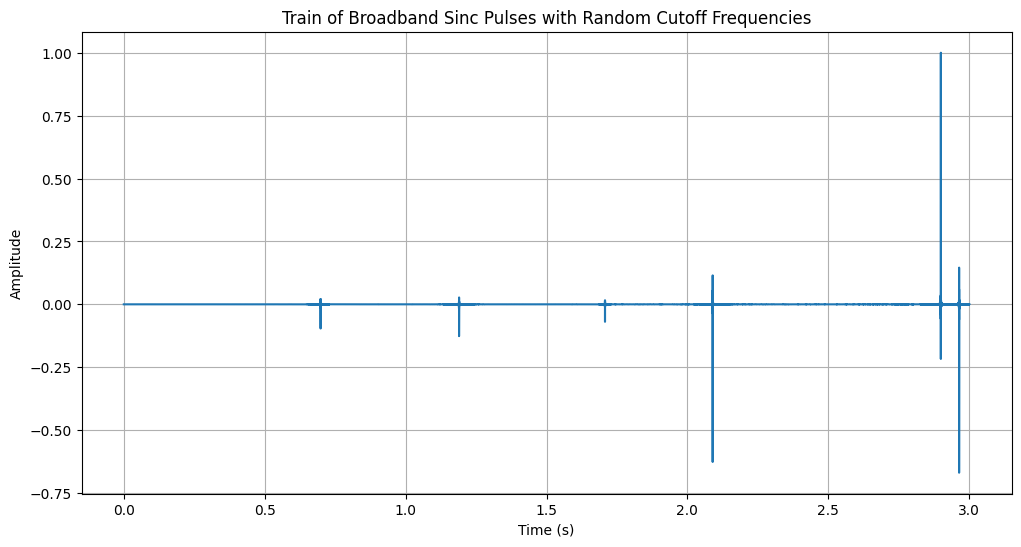

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchaudio
import numpy as np

# Set parameters
sample_rate = 44100  # Hz
duration = 3  # seconds
num_samples = int(sample_rate * duration)
time = torch.linspace(0, duration, num_samples)

# Nyquist frequency is half the sample rate
nyquist_freq = sample_rate / 2  # 22050 Hz

# Cutoff ratio range (how close to Nyquist)
min_cutoff_ratio = 0.1  # Minimum cutoff ratio (70% of Nyquist)
max_cutoff_ratio = 0.99  # Maximum cutoff ratio (95% of Nyquist)

# Gain parameters
min_gain = 0.2
max_gain = 1.0

# Function to create a sinc pulse with specified cutoff frequency
def sinc_pulse(t, center, cutoff_freq, gain):
    # For a lowpass filter, the sinc function is scaled by 2*cutoff_freq
    normalized_t = 2 * cutoff_freq * (t - center)
    
    # Handle the special case where normalized_t is close to zero
    zero_indices = torch.abs(normalized_t) < 1e-10
    result = torch.zeros_like(normalized_t)
    result[zero_indices] = 2 * cutoff_freq  # The peak value
    
    # Calculate sinc for non-zero values
    non_zero = ~zero_indices
    result[non_zero] = 2 * cutoff_freq * torch.sin(torch.pi * normalized_t[non_zero]) / (torch.pi * normalized_t[non_zero])

    # flip polarity with a probability of 50%
    if torch.rand(1).item() < 0.5:
        result = -result
    
    # Apply gain
    return gain * result

# Generate random pulse locations
mean_pulse_rate = 3  # Average number of pulses per second
total_pulses = int(mean_pulse_rate * duration)
pulse_times = torch.sort(torch.rand(total_pulses) * duration)[0]

# Generate random gains for each pulse
pulse_gains = min_gain + (max_gain - min_gain) * torch.rand(total_pulses)

# Generate random cutoff ratios for each pulse
pulse_cutoff_ratios = min_cutoff_ratio + (max_cutoff_ratio - min_cutoff_ratio) * torch.rand(total_pulses)
pulse_cutoff_freqs = pulse_cutoff_ratios * nyquist_freq

print(f"Sample rate: {sample_rate} Hz")
print(f"Nyquist frequency: {nyquist_freq} Hz")
print(f"Cutoff frequency range: {min_cutoff_ratio*100:.0f}% to {max_cutoff_ratio*100:.0f}% of Nyquist")
print(f"Number of pulses: {total_pulses}")

# Create the signal
signal = torch.zeros(num_samples)
for i, pulse_time in enumerate(pulse_times):
    cutoff_freq = pulse_cutoff_freqs[i]
    pulse = sinc_pulse(time, pulse_time, cutoff_freq, pulse_gains[i])
    signal += pulse

# Normalize the signal to avoid clipping
if torch.max(torch.abs(signal)) > 0:
    signal = signal / torch.max(torch.abs(signal))

# Convert to audio format
audio = signal.unsqueeze(0)  # Add channel dimension

# Save the audio file
torchaudio.save('sinc_pulse_train_random_cutoff.wav', audio, sample_rate)

# Plot the signal
plt.figure(figsize=(12, 6))
plt.plot(time.numpy(), signal.numpy())
plt.title(f'Train of Broadband Sinc Pulses with Random Cutoff Frequencies')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [4]:
audio.shape

torch.Size([1, 132300])